In [1]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import text_flappy_bird_gym
from Agents.MonteCarloAgent import MonteCarloAgent
from Agents.SarsaLambdaAgent import SarsaLambdaAgent
from Src.utils import *

# MonteCarlo

## Training

  0%|          | 0/2000 [00:00<?, ?it/s]

Entraînement terminé. L'agent a appris une politique !


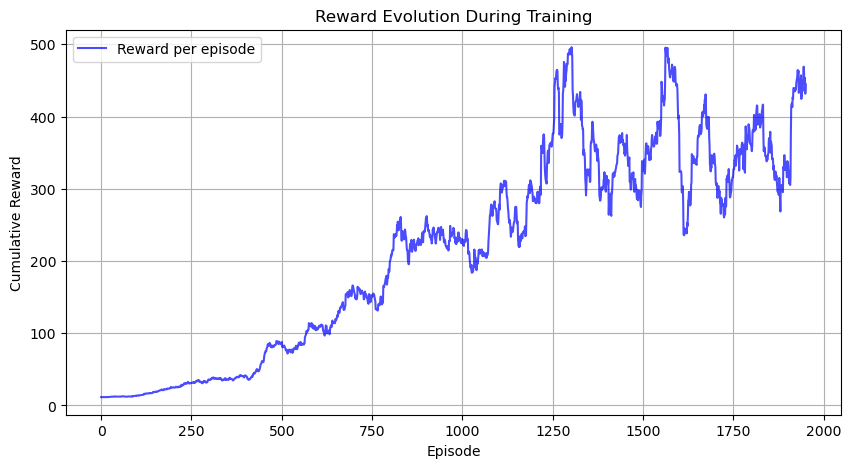

In [7]:
if __name__ == '__main__':
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = MonteCarloAgent(env, epsilon=1.0, gamma=0.96, alpha=0.1)

    num_episodes = 2000  # Nombre d'épisodes d'entraînement
    reward_history = []

    epsilon_min = 0.01  # Exploration minimale
    epsilon_decay = 0.995  # Réduction progressive

    for episode in tqdm(range(num_episodes)):
        obs, _ = env.reset()
        trajectory = []  # Stocke les (état, action, récompense)
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(obs)  # Utilise la politique de l'agent
            next_obs, reward, done, _, info = env.step(action)
            trajectory.append((obs, action, reward))  # Stocke la transition
            obs = next_obs
            total_reward += reward

        reward_history.append(total_reward)

        agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)
        agent.update_policy(trajectory)  # Mise à jour Monte Carlo après l'épisode


    print("Entraînement terminé. L'agent a appris une politique !")
    smoothed_rewards = moving_average(reward_history, window_size=50)
    plot_rewards(smoothed_rewards)

The **Cumulative Reward** curve is increasing, although sometimes the second 1000 episodes may be noisy. The results are quite good with a final cumulative reward around 300-500 !

## Results

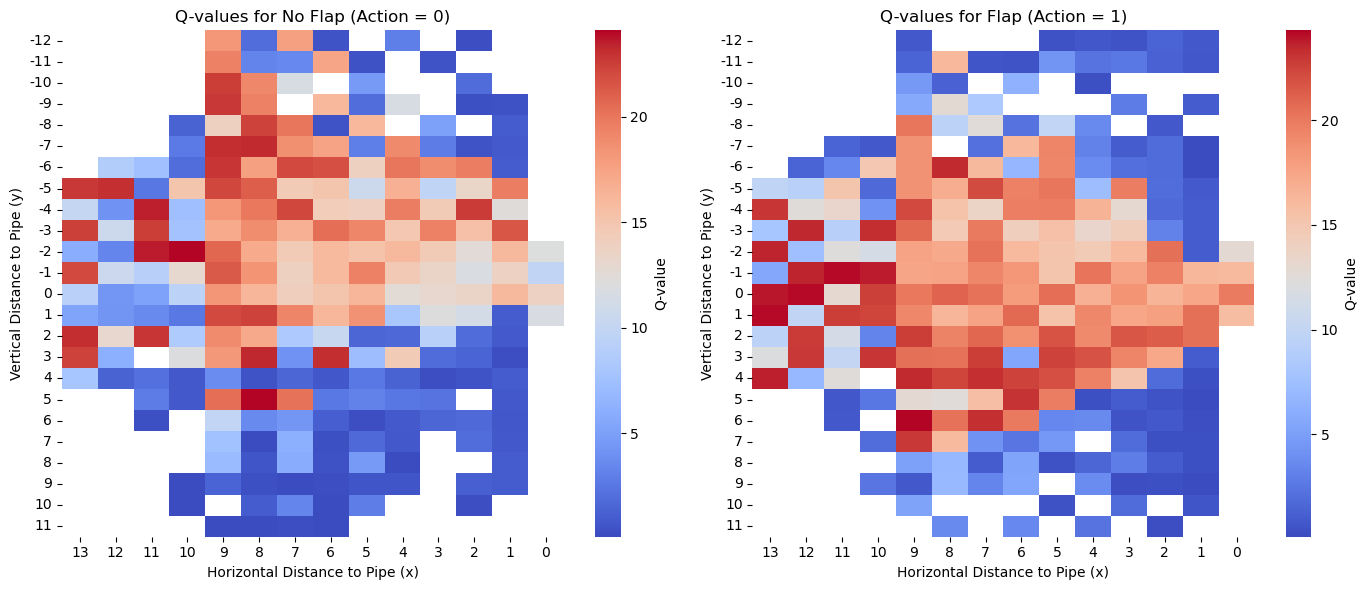

In [8]:
plot_q_values(agent.Q)

The **Q-values Matrix** shows that the agent learnt well. 

Effectively, for the left graph, we are more likely to **not Flap** when the vertical distance with the next pipe is high. This means that **if we are high in the sky, we let the bird fly and fall with the gravity**.

In the contrary, for the right graph, we are more likely to **Flap** if the vertical ditance to the next pipe is low. Which means that **if we are near to the ground, we will flap to gain altitude**.

Finally, in both graphs, we see that when the vertical and horizontal distances are near 0, both actions can be taken. This means that **if we are flying at the good altitude we wait for the bird to pass the pipe**.

**NB** : The vertical distance is positive when the bird is under the next pipe center, and negative when above it. 

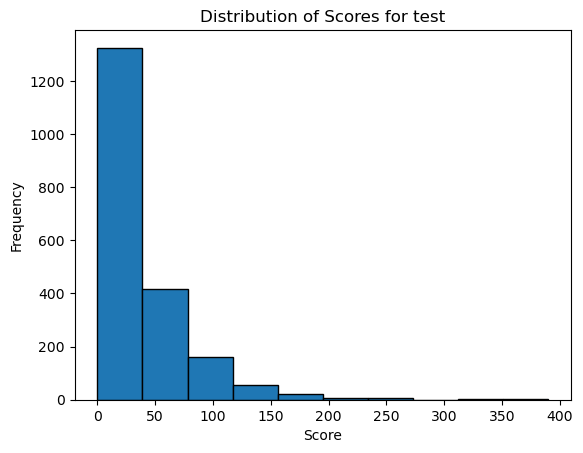

In [9]:
scores = []
states = [state for state, action in agent.Q.keys()]

for i in range(2000):

  obs, _ = env.reset()
  done = False

  while not done:
      # Sélection de la meilleure action selon la politique entraînée
      state = tuple(obs)
      if state in states:
        action = agent.select_action(obs)
      else:
        action = env.action_space.sample()  # Action aléatoire si état inconnu

      obs, reward, done, _, info = env.step(action)
  scores.append(info["score"])

env.close()

plt.hist(scores, edgecolor="black")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores for test")
plt.show()

With this graph, we see that over 2000 try, a lot are around 0-100, and few of them can go above this, until around 300 or 400. 

**NB** The distribution depend on the agent performances, and the graph might change if we recompute the notebook.

In [5]:
# Test
obs, _ = env.reset()
done = False
states = [state for state, action in agent.Q.keys()]

while not done:
    # Rendu du jeu
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Contrôle de la vitesse d'affichage

    # Sélection de la meilleure action selon la politique entraînée
    state = tuple(obs)
    if state in states:
      action = agent.select_action(obs)
      #action = max(agent.Q[state], key=agent.Q[state].get)  # Exploitation
    else:
        action = env.action_space.sample()  # Action aléatoire si état inconnu

    obs, reward, done, _, info = env.step(action)

print("Test terminé, score final :", info["score"])
env.close()

Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                    ]
[                    ]
[      @             ]
[                    ]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=13,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[       

We can try manually a Flappyird game and see directly how far the agent is abale to go !

# Sarsa

## Training

In [2]:
if __name__ == '__main__':
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    
    # Récupère la taille de l'espace d'actions
    action_size = env.action_space.n
    state_shape = (14, 22)  # Tuple observation space: Discrete(14), Discrete(22)
    
    # Initialise l'agent Sarsa(λ) avec les paramètres nécessaires
    agent = SarsaLambdaAgent(state_size=state_shape, action_size=action_size, alpha=0.1, gamma=0.96, lambd=0.9, epsilon=1.0)

    num_episodes = 2000  # Nombre d'épisodes d'entraînement
    reward_history = []

    epsilon_min = 0.01  # Exploration minimale
    epsilon_decay = 0.995  # Réduction progressive

    for episode in tqdm(range(num_episodes)):
        obs, _ = env.reset()
        trajectory = []  # Stocke les (état, action, récompense)
        done = False
        total_reward = 0

        # Initialisation de l'action avec la méthode de sélection
        action = agent.select_action(obs)

        while not done:
            next_obs, reward, done, _, info = env.step(action)
            next_action = agent.select_action(next_obs)

            # Ajoute la transition à la trajectoire
            trajectory.append((obs, action, reward))

            # Mise à jour de l'agent avec la transition
            agent.update_policy(obs, action, reward, next_obs, next_action, done)

            obs = next_obs
            action = next_action
            total_reward += reward

        reward_history.append(total_reward)

        # Diminution progressive de l'exploration
        agent.epsilon = max(epsilon_min, agent.epsilon * epsilon_decay)

    print("Entraînement terminé. L'agent a appris une politique !")

    # Affichage des récompenses moyennes
    smoothed_rewards = moving_average(reward_history, window_size=50)
    plot_rewards(smoothed_rewards)

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (2,2) (14,22,2) 

In [4]:
env.observation_space

Tuple(Discrete(14), Discrete(22, start=-11))

## Results